<a href="https://colab.research.google.com/github/Topspinner04/AAI-Project-SS25/blob/main/xAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Comparison of Feature Attribution Parsimony xAI Metrics - Test Task**

First, we need to import the required Python packages:

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sklearn.model_selection as model_selection
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing

Loading the Breast Cancer dataset:

In [4]:
cancer = datasets.load_breast_cancer()

Creating a DataFrame for preprocessing:

In [5]:
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['target'] = cancer.target

Splitting data into features and target:

In [6]:
X = data.drop('target', axis=1)
y = data['target']

Standardize features:

In [7]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

Split data:

In [8]:
X_train, X_temp, y_train, y_temp = model_selection.train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

Creating a custom dataset class for use in PyTorch:

In [9]:
class BreastCancerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Creating our own dataset objects:

In [10]:
train_dataset = BreastCancerDataset(X_train, y_train.values)
val_dataset = BreastCancerDataset(X_val, y_val.values)
test_dataset = BreastCancerDataset(X_test, y_test.values)

Load data:

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Define Neural Network:

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Init model:

In [35]:
input_size = X_train.shape[1]  # Number of features
model = SimpleNN(input_size)

Define loss function and optimizer:

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training function:

In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_val_acc = correct / total
        val_accuracies.append(epoch_val_acc)

        # Print statistics
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return train_losses, val_losses, val_accuracies

Train the model:

In [38]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Epoch 10/50:
Train Loss: 0.7094, Val Loss: 0.7275, Val Acc: 0.5529
Epoch 20/50:
Train Loss: 0.7094, Val Loss: 0.7275, Val Acc: 0.5529
Epoch 30/50:
Train Loss: 0.7094, Val Loss: 0.7275, Val Acc: 0.5529
Epoch 40/50:
Train Loss: 0.7094, Val Loss: 0.7275, Val Acc: 0.5529
Epoch 50/50:
Train Loss: 0.7094, Val Loss: 0.7275, Val Acc: 0.5529


We are now using matplotlib to plot the accuracy over epochs:

Text(0.5, 0, 'Epochs')

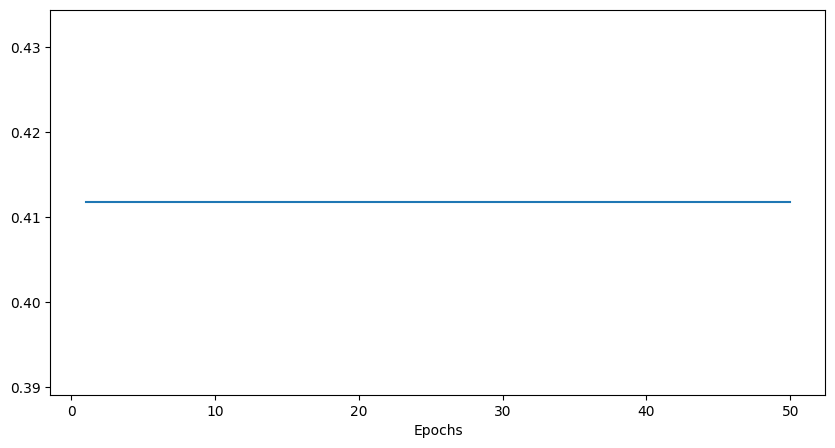

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')

Test the model:

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 1.0000
